<a href="https://colab.research.google.com/github/jeojildo/trainingdata/blob/main/p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# 🔑 Use the RAW GitHub link to read the data directly
url = "https://raw.githubusercontent.com/jeojildo/trainingdata/main/Teste%20GC-FID.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

# Print the first 5 rows to verify
print("✅ File successfully loaded!")
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

# Or just display the DataFrame for a nicer table output in Colab
# df

✅ File successfully loaded!

First 5 rows of the DataFrame:
  Bobonaro 1&2;;;;Manatutu1&2;;;;Viqueque1&2;;;;Suai1&2;;;;Baucau1&2;;;
0          B1;;B2;;M1;;M2;;V1;;V2;;S1;;S2;;Ba1;;Ba2;                   
1  RT;MA;RT;MA;RT;MA;RT;MA;RT;MA;RT;MA;RT;MA;RT;M...                   
2  1.58;6818126;1.58;1290190;1.58;830165;1.59;106...                   
3  2.45;17069414;2.50;15333157;2.52;248664706;2.5...                   
4  3.28;3003788115;3.25;3496856512;3.19;374499865...                   


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

# 1. Tentukan URL dan Parameter Data
url = "https://raw.githubusercontent.com/jeojildo/trainingdata/main/Teste%20GC-FID.csv"
# Asumsi data di dalam file CSV dipisahkan oleh spasi (r'\s+') berdasarkan struktur yang Anda berikan
samples = ['B1', 'B2', 'M1', 'M2', 'V1', 'V2', 'S1', 'S2', 'Ba1', 'Ba2']

# Label yang lebih deskriptif untuk sumbu Y (Sample)
y_labels = [
    'Bobonaro 1 (B1)', 'Bobonaro 2 (B2)', 'Manatutu 1 (M1)', 'Manatutu 2 (M2)',
    'Viqueque 1 (V1)', 'Viqueque 2 (V2)', 'Suai 1 (S1)', 'Suai 2 (S2)',
    'Baucau 1 (Ba1)', 'Baucau 2 (Ba2)'
]

# 2. Muat dan Bersihkan Data
try:
    # Membaca data dengan multi-index header
    df_raw = pd.read_csv(url, sep=r'\s+', header=[0, 1], skipinitialspace=True)
except Exception as e:
    print(f"Error saat membaca file dari URL: {e}")
    print("Pastikan format file di URL adalah spasi/tab-separated dan memiliki 2 baris header.")
    exit()

# Flatten kolom multi-indeks (misalnya: 'B1_RT', 'B1_MA')
df_raw.columns = ['_'.join(col).strip() for col in df_raw.columns.values]
# Hapus baris yang sepenuhnya kosong
df_raw = df_raw.dropna(how='all')

# Buat DataFrame yang diurutkan untuk plotting
df = pd.DataFrame()
for s in samples:
    df[f'{s}_RT'] = df_raw[f'{s}_RT']
    df[f'{s}_MA'] = df_raw[f'{s}_MA']

# Tentukan parameter plot
y_offset = 1.0e9 # Offset (jarak) antar sampel di sumbu Y (diatur besar karena nilai MA besar)
min_intensity = 1e6 # Batas minimal MA agar puncak dipertimbangkan (untuk cleaning)

# 3. Pembuatan Plot Waterfall 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

verts = []
zs = []

for i, sample in enumerate(samples):
    rt_col = f'{sample}_RT'
    ma_col = f'{sample}_MA'

    # Dapatkan data RT dan MA, drop NaN
    rt_data = df[rt_col].dropna().values
    ma_data = df[ma_col].dropna().values

    # Filter data dengan intensitas (MA) di atas batas minimal
    rt_filtered = rt_data[ma_data > min_intensity]
    ma_filtered = ma_data[ma_data > min_intensity]

    # Menambahkan titik nol (baseline) untuk membuat bentuk puncak kromatogram yang utuh
    rt_full = [0]
    ma_full = [0]

    for rt, ma in zip(rt_filtered, ma_filtered):
        # Tambahkan titik di dekat baseline sebelum puncak
        if rt - 0.1 > rt_full[-1]:
            rt_full.append(rt - 0.05)
            ma_full.append(0)

        # Titik puncak
        rt_full.append(rt)
        ma_full.append(ma)

        # Tambahkan titik di dekat baseline setelah puncak
        rt_full.append(rt + 0.05)
        ma_full.append(0)

    # Titik akhir kromatogram (baseline)
    max_rt_global = 25 # Asumsi RT maksimum
    if rt_full[-1] < max_rt_global:
         rt_full.append(max_rt_global)
         ma_full.append(0)

    rt_arr = np.array(rt_full)
    ma_arr = np.array(ma_full)

    # Posisi Z (sumbu Y di visualisasi)
    z_pos = i * y_offset
    zs.append(z_pos)
    verts.append(list(zip(rt_arr, ma_arr)))

    # Plot garis kromatogram di 3D
    # X=RT, Y=Sample Position (z_pos), Z=Intensity (MA)
    ax.plot(rt_arr, [z_pos] * len(rt_arr), ma_arr, color='k', linewidth=1)

# Membuat PolyCollection untuk mengisi area di bawah puncak (waterfall effect)
# ColorMap digunakan agar warna mengikuti posisi di sumbu Y
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(np.min(zs), np.max(zs))
facecolors = cmap(norm(zs))

poly = PolyCollection(verts, facecolors=facecolors, edgecolors='k', linewidths=0.5, alpha=0.5)
ax.add_collection3d(poly, zs=zs, zdir='y')

# --- KUSTOMISASI PLOT ---
ax.set_xlabel('RT (min)', fontsize=12)
ax.set_zlabel('Intensity (MA)', fontsize=12)
ax.set_ylabel('Sample', fontsize=12)

# Mengatur batas sumbu X (RT)
ax.set_xlim(0, max_rt_global + 1)

# Mengatur batas sumbu Y (Sample) dan labelnya
ax.set_ylim(-y_offset/2, len(samples) * y_offset)
ax.set_yticks(zs)
ax.set_yticklabels(y_labels, rotation=-15, ha='left')

# Mengatur batas sumbu Z (Intensitas)
max_ma = df[[f'{s}_MA' for s in samples]].max().max()
z_max_limit = np.ceil(max_ma / 1e9) * 1e9 if max_ma > 1e9 else np.ceil(max_ma / 5e8) * 5e8
ax.set_zlim(0, z_max_limit)
ax.ticklabel_format(axis='z', style='sci', scilimits=(0, 0)) # Notasi ilmiah untuk MA

# Mengubah Sudut Pandang (View Angle)
ax.view_init(elev=35, azim=-55)

plt.title('Kromatogram GC-FID Waterfall Plot (Data GitHub)', fontsize=14)
plt.tight_layout()
plt.show()

print("\nDetail Komponen pada Plot (Sesuai Keterangan Gambar Awal):")
print("IS - Internal Standard")
print("1 - Acetaldehyde")
print("2 - Ethyl Acetate")
print("3 - Methanol")
print("4 - Propanol")
print("5 - Isobutanol")
print("6 - 3-Methyl-Butanol")

Error saat membaca file dari URL: Header rows must have an equal number of columns.
Pastikan format file di URL adalah spasi/tab-separated dan memiliki 2 baris header.


NameError: name 'df_raw' is not defined

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

# 1. Tentukan URL dan Parameter Data
url = "https://github.com/jeojildo/trainingdata/blob/main/testedata.csv"
samples = ['B1', 'B2', 'M1', 'M2', 'V1', 'V2', 'S1', 'S2', 'Ba1', 'Ba2']

# Label yang lebih deskriptif untuk sumbu Y (Sample)
y_labels = [
    'Bobonaro 1 (B1)', 'Bobonaro 2 (B2)', 'Manatutu 1 (M1)', 'Manatutu 2 (M2)',
    'Viqueque 1 (V1)', 'Viqueque 2 (V2)', 'Suai 1 (S1)', 'Suai 2 (S2)',
    'Baucau 1 (Ba1)', 'Baucau 2 (Ba2)'
]

# Urutan kolom yang benar (RT1, MA1, RT2, MA2, dst.)
column_order = []
for s in samples:
    column_order.append(f'{s}_RT')
    column_order.append(f'{s}_MA')

# 2. Strategi Pembacaan dan Pembersihan Data yang Diperbaiki
print("Mencoba membaca data dari URL...")

# Baca data tanpa header, mulai dari baris 3 (indeks 2)
# Baris 0: Bobonaro 1&2 ...
# Baris 1: B1 B2 ...
# Baris 2: RT MA RT MA ...
# Baris 3 dan seterusnya adalah data aktual.
# Kita gunakan header=2 untuk mengambil baris 'RT MA' sebagai header, dan kemudian mengganti nama kolomnya.
try:
    # Membaca data dengan asumsi baris 'RT MA...' adalah header
    # dan memisahkan berdasarkan satu atau lebih spasi/tab
    df_raw = pd.read_csv(url, sep=r'\s+', header=2, skipinitialspace=True)
except Exception as e:
    print(f"Gagal membaca file dari URL bahkan dengan strategi baru: {e}")
    exit()

# Menetapkan kembali nama kolom sesuai urutan yang kita inginkan
# Data memiliki 10 pasang (RT, MA), jadi total 20 kolom data
new_column_names = column_order

# Periksa apakah jumlah kolom data sama dengan jumlah kolom yang diharapkan (20)
if df_raw.shape[1] < len(new_column_names):
     # Jika ada kolom yang kurang, asumsikan Pandas secara otomatis menghapus kolom index pertama
     # yang tidak ada namanya. Kita ambil 20 kolom terakhir.
     df_raw = df_raw.iloc[:, -len(new_column_names):]

# Setel nama kolom yang baru
df_raw.columns = new_column_names

# Hapus baris yang sepenuhnya NaN setelah pembacaan
df = df_raw.dropna(how='all').reset_index(drop=True)

print("Pembacaan data berhasil. Lanjut ke pembuatan plot...")


# Tentukan parameter plot
y_offset = 1.0e9 # Offset (jarak) antar sampel di sumbu Y (diatur besar karena nilai MA besar)
min_intensity = 1e6 # Batas minimal MA agar puncak dipertimbangkan (untuk cleaning)

# 3. Pembuatan Plot Waterfall 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

verts = []
zs = []

for i, sample in enumerate(samples):
    rt_col = f'{sample}_RT'
    ma_col = f'{sample}_MA'

    # Dapatkan data RT dan MA, drop NaN
    # Gunakan .values untuk mendapatkan array numpy
    rt_data = df[rt_col].dropna().values
    ma_data = df[ma_col].dropna().values

    # Filter data dengan intensitas (MA) di atas batas minimal
    rt_filtered = rt_data[ma_data > min_intensity]
    ma_filtered = ma_data[ma_data > min_intensity]

    # Menambahkan titik nol (baseline) untuk membuat bentuk puncak kromatogram yang utuh
    rt_full = [0]
    ma_full = [0]

    for rt, ma in zip(rt_filtered, ma_filtered):
        # Tambahkan titik di dekat baseline sebelum puncak
        if rt - 0.1 > rt_full[-1]:
            rt_full.append(rt - 0.05)
            ma_full.append(0)

        # Titik puncak
        rt_full.append(rt)
        ma_full.append(ma)

        # Tambahkan titik di dekat baseline setelah puncak
        rt_full.append(rt + 0.05)
        ma_full.append(0)

    # Titik akhir kromatogram (baseline)
    max_rt_global = 25 # Asumsi RT maksimum
    if rt_full[-1] < max_rt_global:
         rt_full.append(max_rt_global)
         ma_full.append(0)

    rt_arr = np.array(rt_full)
    ma_arr = np.array(ma_full)

    # Posisi Z (sumbu Y di visualisasi)
    z_pos = i * y_offset
    zs.append(z_pos)
    verts.append(list(zip(rt_arr, ma_arr)))

    # Plot garis kromatogram di 3D
    # X=RT, Y=Sample Position (z_pos), Z=Intensity (MA)
    ax.plot(rt_arr, [z_pos] * len(rt_arr), ma_arr, color='k', linewidth=1)

# Membuat PolyCollection untuk mengisi area di bawah puncak (waterfall effect)
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(np.min(zs), np.max(zs))
facecolors = cmap(norm(zs))

poly = PolyCollection(verts, facecolors=facecolors, edgecolors='k', linewidths=0.5, alpha=0.5)
ax.add_collection3d(poly, zs=zs, zdir='y')

# --- KUSTOMISASI PLOT ---
ax.set_xlabel('RT (min)', fontsize=12)
ax.set_zlabel('Intensity (MA)', fontsize=12)
ax.set_ylabel('Sample', fontsize=12)

# Mengatur batas sumbu X (RT)
ax.set_xlim(0, max_rt_global + 1)

# Mengatur batas sumbu Y (Sample) dan labelnya
ax.set_ylim(-y_offset/2, len(samples) * y_offset)
ax.set_yticks(zs)
ax.set_yticklabels(y_labels, rotation=-15, ha='left')

# Mengatur batas sumbu Z (Intensitas)
# Nilai MA max ditemukan di seluruh data, lalu dibulatkan ke atas
max_ma = df[[f'{s}_MA' for s in samples]].max().max()
z_max_limit = np.ceil(max_ma / 1e9) * 1e9 if max_ma > 1e9 else np.ceil(max_ma / 5e8) * 5e8
ax.set_zlim(0, z_max_limit)
ax.ticklabel_format(axis='z', style='sci', scilimits=(0, 0)) # Notasi ilmiah untuk MA

# Mengubah Sudut Pandang (View Angle)
ax.view_init(elev=35, azim=-55)

plt.title('Kromatogram GC-FID Waterfall Plot (Data GitHub)', fontsize=14)
plt.tight_layout()
plt.show()

print("\nDetail Komponen pada Plot (Sesuai Keterangan Gambar Awal):")
print("IS - Internal Standard")
print("1 - Acetaldehyde")
print("2 - Ethyl Acetate")
print("3 - Methanol")
print("4 - Propanol")
print("5 - Isobutanol")
print("6 - 3-Methyl-Butanol")

Mencoba membaca data dari URL...
Gagal membaca file dari URL bahkan dengan strategi baru: Error tokenizing data. C error: Expected 3 fields in line 25, saw 4



ValueError: Length mismatch: Expected axis has 1 elements, new values have 20 elements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from io import StringIO

# Data yang Diberikan (diambil dari pertanyaan pertama user)
data_mentah = """
Bobonaro 1&2                      Manatutu1&2                       Viqueque1&2                       Suai1&2                       Baucau1&2
B1      B2      M1      M2      V1      V2      S1      S2      Ba1      Ba2
RT  MA  RT  MA  RT  MA  RT  MA  RT  MA  RT  MA  RT  MA  RT  MA  RT  MA  RT  MA
1.58    6818126 1.58    1290190 1.58    830165  1.59    1061075 0.97    28407 1.58    1166667 1.58    2028147 1.59    1233300 1.58    1121296 1.04    14757
2.45    17069414    2.50    15333157    2.52    248664706   2.50    7509304 1.03    7522  2.41    21709432    2.50    7096338 2.51    3657992 2.49    47391667    1.05    87986
3.28    3003788115  3.25    3496856512  3.19    3744998654  3.21    1992955623  1.06    517344    2.61    9187313 3.17    2239315659  2.63    38510141    3.15    2818971432  1.08    50640
5.34    6018977 5.54    4972067 5.58    49068772    12.92   367976526   1.16    3791  3.38    2514941211  5.04    5313583 3.19    2413785924  5.05    2648158 1.32    189077
10.20   27026301    13.16   605234158   11.84   14740110    19.14   6082072 1.58    1924677 5.03    2742187 5.31    7739818 5.06    4955929 5.48    9452628 1.59    2644613
12.60   362163081   14.54   12349386    13.07   563189920   22.07   9042887 2.50    173864633   5.45    8448704 5.47    3878557 5.50    6320802 12.87   341320107   2.52    109481056
14.14   10309836    19.17   7938603 14.48   8965393                     3.15    4577866986  12.81   292951603   11.66   7154209 13.02   464423027   14.37   6134703 3.63    51127118354
18.94   9460983 22.08   11880292    19.15   6211578                     5.57    9582829 14.33   5740599 12.92   331285488   14.09   5351365 17.23   304409  5.22    3345556
22.08   6361494                 22.08   16202512                    8.48    2084056 19.08   4083013 14.41   11272588    14.46   7269865 19.12   2279167 5.69    19650547
                                    13.03   570971933   22.05   9763066 22.09   3186378 19.14   5319847 21.99   4348158 12.54   480065
                                    14.45   7386109 27.44   252434    24.42   29969709    22.09   10651769                13.08   554249004
                                    17.05   18562640    28.30   1930415                 22.44   4474242                 14.49   21539465
                                    19.14   11950983    28.31   3796552
                                    21.94   21354
                                    21.95   54616635
                                    23.10   777487
"""

# 1. Tentukan Nama Sampel dan Label
samples = ['B1', 'B2', 'M1', 'M2', 'V1', 'V2', 'S1', 'S2', 'Ba1', 'Ba2']

# Label yang lebih deskriptif untuk sumbu Y (Sample)
y_labels = [
    'Bobonaro 1 (B1)', 'Bobonaro 2 (B2)', 'Manatutu 1 (M1)', 'Manatutu 2 (M2)',
    'Viqueque 1 (V1)', 'Viqueque 2 (V2)', 'Suai 1 (S1)', 'Suai 2 (S2)',
    'Baucau 1 (Ba1)', 'Baucau 2 (Ba2)'
]

# 2. Muat dan Bersihkan Data dari String
# Memuat data ke Pandas DataFrame menggunakan StringIO dan multi-index header
try:
    df_raw = pd.read_csv(StringIO(data_mentah), sep=r'\s+', header=[1, 2], skipinitialspace=True)
except Exception as e:
    # Jika multi-index header gagal (seperti error sebelumnya), coba strategi header baris 2
    try:
        df_raw = pd.read_csv(StringIO(data_mentah), sep=r'\s+', header=2, skipinitialspace=True)
        column_order = []
        for s in samples:
            column_order.append(f'{s}_RT')
            column_order.append(f'{s}_MA')
        if df_raw.shape[1] > len(column_order):
            df_raw = df_raw.iloc[:, -len(column_order):]
        df_raw.columns = column_order
    except Exception as e_final:
        print(f"Gagal memproses data string, periksa format data mentah: {e_final}")
        exit()

# Flatten kolom multi-indeks jika berhasil
if isinstance(df_raw.columns, pd.MultiIndex):
    df_raw.columns = ['_'.join(col).strip() for col in df_raw.columns.values]

# Hapus baris yang sepenuhnya NaN setelah pembacaan
df_raw = df_raw.dropna(how='all')

# Buat DataFrame yang diurutkan untuk plotting
df = pd.DataFrame()
for s in samples:
    df[f'{s}_RT'] = df_raw[f'{s}_RT']
    df[f'{s}_MA'] = df_raw[f'{s}_MA']

# Tentukan parameter plot
y_offset = 1.0e9 # Offset (jarak) antar sampel di sumbu Y (disesuaikan dengan nilai MA)
min_intensity = 1e6 # Batas minimal MA agar puncak dipertimbangkan

# 3. Pembuatan Plot Waterfall 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

verts = []
zs = []

for i, sample in enumerate(samples):
    rt_col = f'{sample}_RT'
    ma_col = f'{sample}_MA'

    # Dapatkan data RT dan MA, drop NaN
    rt_data = df[rt_col].dropna().values
    ma_data = df[ma_col].dropna().values

    # Filter data dengan intensitas (MA) di atas batas minimal
    rt_filtered = rt_data[ma_data > min_intensity]
    ma_filtered = ma_data[ma_data > min_intensity]

    # Menambahkan titik nol (baseline) untuk membuat bentuk puncak kromatogram yang utuh
    rt_full = [0]
    ma_full = [0]

    for rt, ma in zip(rt_filtered, ma_filtered):
        # Tambahkan titik di dekat baseline sebelum puncak
        if rt - 0.1 > rt_full[-1]:
            rt_full.append(rt - 0.05)
            ma_full.append(0)

        # Titik puncak
        rt_full.append(rt)
        ma_full.append(ma)

        # Tambahkan titik di dekat baseline setelah puncak
        rt_full.append(rt + 0.05)
            ma_full.append(0)

    # Titik akhir kromatogram (baseline)
    max_rt_global = 25 # Asumsi RT maksimum
    if rt_full[-1] < max_rt_global:
         rt_full.append(max_rt_global)
         ma_full.append(0)

    rt_arr = np.array(rt_full)
    ma_arr = np.array(ma_full)

    # Posisi Z (sumbu Y di visualisasi)
    z_pos = i * y_offset
    zs.append(z_pos)
    verts.append(list(zip(rt_arr, ma_arr)))

    # Plot garis kromatogram di 3D
    # X=RT, Y=Sample Position (z_pos), Z=Intensity (MA)
    ax.plot(rt_arr, [z_pos] * len(rt_arr), ma_arr, color='k', linewidth=1)

# Membuat PolyCollection untuk mengisi area di bawah puncak (waterfall effect)
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(np.min(zs), np.max(zs))
facecolors = cmap(norm(zs))

poly = PolyCollection(verts, facecolors=facecolors, edgecolors='k', linewidths=0.5, alpha=0.5)
ax.add_collection3d(poly, zs=zs, zdir='y')

# --- KUSTOMISASI PLOT ---
ax.set_xlabel('RT (min)', fontsize=12)
ax.set_zlabel('Intensity (MA)', fontsize=12)
ax.set_ylabel('Sample', fontsize=12)

# Mengatur batas sumbu X (RT)
ax.set_xlim(0, max_rt_global + 1)

# Mengatur batas sumbu Y (Sample) dan labelnya
ax.set_ylim(-y_offset/2, len(samples) * y_offset)
ax.set_yticks(zs)
ax.set_yticklabels(y_labels, rotation=-15, ha='left')

# Mengatur batas sumbu Z (Intensitas)
max_ma = df[[f'{s}_MA' for s in samples]].max().max()
z_max_limit = np.ceil(max_ma / 1e9) * 1e9 if max_ma > 1e9 else np.ceil(max_ma / 5e8) * 5e8
ax.set_zlim(0, z_max_limit)
ax.ticklabel_format(axis='z', style='sci', scilimits=(0, 0)) # Notasi ilmiah untuk MA

# Mengubah Sudut Pandang (View Angle)
ax.view_init(elev=35, azim=-55)

plt.title('Kromatogram GC-FID Waterfall Plot (Data Mentah)', fontsize=14)
plt.tight_layout()
plt.savefig('kromatogram_waterfall_3d.png')
plt.close()

print("Plot kromatogram waterfall 3D telah berhasil dibuat: kromatogram_waterfall_3d.png")
print("\nDetail Komponen pada Plot (Sesuai Keterangan Gambar Awal):")
print("IS - Internal Standard")
print("1 - Acetaldehyde")
print("2 - Ethyl Acetate")
print("3 - Methanol")
print("4 - Propanol")
print("5 - Isobutanol")
print("6 - 3-Methyl-Butanol")<ctrl46>}

IndentationError: unexpected indent (ipython-input-169894316.py, line 112)

/tmp/ipython-input-3328745268.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')
/tmp/ipython-input-3328745268.py:157: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


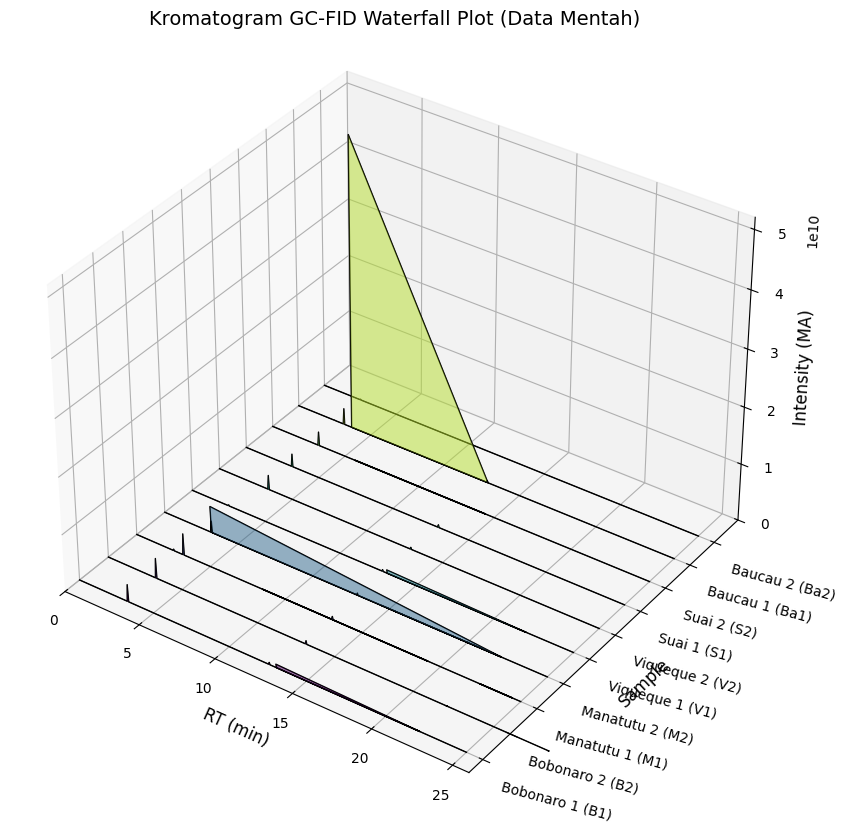

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from io import StringIO

# Data yang Diberikan (diambil dari pertanyaan pertama user)
data_mentah = """
Bobonaro 1&2                      Manatutu1&2                       Viqueque1&2                       Suai1&2                       Baucau1&2
B1      B2      M1      M2      V1      V2      S1      S2      Ba1      Ba2
RT  MA  RT  MA  RT  MA  RT  MA  RT  MA  RT  MA  RT  MA  RT  MA  RT  MA  RT  MA
1.58    6818126 1.58    1290190 1.58    830165  1.59    1061075 0.97    28407 1.58    1166667 1.58    2028147 1.59    1233300 1.58    1121296 1.04    14757
2.45    17069414    2.50    15333157    2.52    248664706   2.50    7509304 1.03    7522  2.41    21709432    2.50    7096338 2.51    3657992 2.49    47391667    1.05    87986
3.28    3003788115  3.25    3496856512  3.19    3744998654  3.21    1992955623  1.06    517344    2.61    9187313 3.17    2239315659  2.63    38510141    3.15    2818971432  1.08    50640
5.34    6018977 5.54    4972067 5.58    49068772    12.92   367976526   1.16    3791  3.38    2514941211  5.04    5313583 3.19    2413785924  5.05    2648158 1.32    189077
10.20   27026301    13.16   605234158   11.84   14740110    19.14   6082072 1.58    1924677 5.03    2742187 5.31    7739818 5.06    4955929 5.48    9452628 1.59    2644613
12.60   362163081   14.54   12349386    13.07   563189920   22.07   9042887 2.50    173864633   5.45    8448704 5.47    3878557 5.50    6320802 12.87   341320107   2.52    109481056
14.14   10309836    19.17   7938603 14.48   8965393                     3.15    4577866986  12.81   292951603   11.66   7154209 13.02   464423027   14.37   6134703 3.63    51127118354
18.94   9460983 22.08   11880292    19.15   6211578                     5.57    9582829 14.33   5740599 12.92   331285488   14.09   5351365 17.23   304409  5.22    3345556
22.08   6361494                 22.08   16202512                    8.48    2084056 19.08   4083013 14.41   11272588    14.46   7269865 19.12   2279167 5.69    19650547
                                    13.03   570971933   22.05   9763066 22.09   3186378 19.14   5319847 21.99   4348158 12.54   480065
                                    14.45   7386109 27.44   252434    24.42   29969709    22.09   10651769                13.08   554249004
                                    17.05   18562640    28.30   1930415                 22.44   4474242                 14.49   21539465
                                    19.14   11950983    28.31   3796552
                                    21.94   21354
                                    21.95   54616635
                                    23.10   777487
"""

# 1. Tentukan Nama Sampel dan Label
samples = ['B1', 'B2', 'M1', 'M2', 'V1', 'V2', 'S1', 'S2', 'Ba1', 'Ba2']

# Label yang lebih deskriptif untuk sumbu Y (Sample)
y_labels = [
    'Bobonaro 1 (B1)', 'Bobonaro 2 (B2)', 'Manatutu 1 (M1)', 'Manatutu 2 (M2)',
    'Viqueque 1 (V1)', 'Viqueque 2 (V2)', 'Suai 1 (S1)', 'Suai 2 (S2)',
    'Baucau 1 (Ba1)', 'Baucau 2 (Ba2)'
]

# 2. Muat dan Bersihkan Data dari String
# Strategi pembacaan untuk data yang dipaste (header baris 2 dan 3)
try:
    df_raw = pd.read_csv(StringIO(data_mentah), sep=r'\s+', header=[1, 2], skipinitialspace=True)
    # Flatten kolom multi-indeks
    df_raw.columns = ['_'.join(col).strip() for col in df_raw.columns.values]
except Exception:
    # Fallback untuk struktur header yang bermasalah (jika multi-index gagal)
    df_raw = pd.read_csv(StringIO(data_mentah), sep=r'\s+', header=2, skipinitialspace=True)
    column_order = []
    for s in samples:
        column_order.append(f'{s}_RT')
        column_order.append(f'{s}_MA')
    if df_raw.shape[1] > len(column_order):
        df_raw = df_raw.iloc[:, -len(column_order):]
    df_raw.columns = column_order

# Hapus baris yang sepenuhnya NaN setelah pembacaan
df_raw = df_raw.dropna(how='all')

# Buat DataFrame yang diurutkan untuk plotting
df = pd.DataFrame()
for s in samples:
    df[f'{s}_RT'] = df_raw[f'{s}_RT']
    df[f'{s}_MA'] = df_raw[f'{s}_MA']

# Tentukan parameter plot
y_offset = 1.0e9 # Offset (jarak) antar sampel di sumbu Y (disesuaikan dengan nilai MA)
min_intensity = 1e6 # Batas minimal MA agar puncak dipertimbangkan

# 3. Pembuatan Plot Waterfall 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

verts = []
zs = []

for i, sample in enumerate(samples):
    rt_col = f'{sample}_RT'
    ma_col = f'{sample}_MA'

    # Dapatkan data RT dan MA, drop NaN
    rt_data = df[rt_col].dropna().values
    ma_data = df[ma_col].dropna().values

    # Filter data dengan intensitas (MA) di atas batas minimal
    rt_filtered = rt_data[ma_data > min_intensity]
    ma_filtered = ma_data[ma_data > min_intensity]

    # Menambahkan titik nol (baseline) untuk membuat bentuk puncak kromatogram yang utuh
    rt_full = [0]
    ma_full = [0]

    for rt, ma in zip(rt_filtered, ma_filtered):
        # Tambahkan titik di dekat baseline sebelum puncak
        if rt - 0.1 > rt_full[-1]:
            rt_full.append(rt - 0.05)
            ma_full.append(0)

        # Titik puncak
        rt_full.append(rt)
        ma_full.append(ma)

        # Tambahkan titik di dekat baseline setelah puncak
        rt_full.append(rt + 0.05)
        ma_full.append(0) # <--- Baris yang bermasalah (Indentation) telah diperbaiki

    # Titik akhir kromatogram (baseline)
    max_rt_global = 25 # Asumsi RT maksimum
    if rt_full[-1] < max_rt_global:
         rt_full.append(max_rt_global)
         ma_full.append(0)

    rt_arr = np.array(rt_full)
    ma_arr = np.array(ma_full)

    # Posisi Z (sumbu Y di visualisasi)
    z_pos = i * y_offset
    zs.append(z_pos)
    verts.append(list(zip(rt_arr, ma_arr)))

    # Plot garis kromatogram di 3D
    # X=RT, Y=Sample Position (z_pos), Z=Intensity (MA)
    ax.plot(rt_arr, [z_pos] * len(rt_arr), ma_arr, color='k', linewidth=1)

# Membuat PolyCollection untuk mengisi area di bawah puncak (waterfall effect)
cmap = plt.cm.get_cmap('viridis')
norm = plt.Normalize(np.min(zs), np.max(zs))
facecolors = cmap(norm(zs))

poly = PolyCollection(verts, facecolors=facecolors, edgecolors='k', linewidths=0.5, alpha=0.5)
ax.add_collection3d(poly, zs=zs, zdir='y')

# --- KUSTOMISASI PLOT ---
ax.set_xlabel('RT (min)', fontsize=12)
ax.set_zlabel('Intensity (MA)', fontsize=12)
ax.set_ylabel('Sample', fontsize=12)

# Mengatur batas sumbu X (RT)
ax.set_xlim(0, max_rt_global + 1)

# Mengatur batas sumbu Y (Sample) dan labelnya
ax.set_ylim(-y_offset/2, len(samples) * y_offset)
ax.set_yticks(zs)
ax.set_yticklabels(y_labels, rotation=-15, ha='left')

# Mengatur batas sumbu Z (Intensitas)
max_ma = df[[f'{s}_MA' for s in samples]].max().max()
z_max_limit = np.ceil(max_ma / 1e9) * 1e9 if max_ma > 1e9 else np.ceil(max_ma / 5e8) * 5e8
ax.set_zlim(0, z_max_limit)
ax.ticklabel_format(axis='z', style='sci', scilimits=(0, 0)) # Notasi ilmiah untuk MA

# Mengubah Sudut Pandang (View Angle)
ax.view_init(elev=35, azim=-55)

plt.title('Kromatogram GC-FID Waterfall Plot (Data Mentah)', fontsize=14)
plt.tight_layout()
plt.show()